### import

In [2]:
import os
import numpy as np
import pandas as pd
from shutil import copyfile

from keras import backend as K
from keras import layers as L
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,EarlyStopping

import cv2
import matplotlib.pyplot as plt

import natsort

from boto3 import client # AWS Polly


## 이미지 부풀리기

In [3]:
a = [0x1100, 0x1102, 0x1103, 0x1105, 0x1106, 0x1102, 0x1107, 0x1109, 0x110C, 
     0x110E, 0x110F, 0x1110, 0x1111, 0x1112, 0x11A8, 0x11AB, 0x11AF, 0x11B7, 0x11B8, 
     0x11BA, 0x11BC, 0x1161, 0x1163, 0x1165, 0x1167, 0x1169, 0x116F, 0x116C,
     0x116D, 0x116E, 0x1172, 0x1173, 0x1175, 0x1162, 0x1166, 0x1168, 0x1174, 0x1176]

### 1. DataImageGenerator 설정

In [3]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(
        rotation_range=5, # 시계방향 회전
        width_shift_range=0.1, # 좌우 이동(1이상일 경우 픽셀, 1이하일 경우 비율)
        height_shift_range=0.1, # 상하 이동(1이상일 경우 픽셀, 1이하일 경우 비율)
        shear_range=0.05, # 찌그러지는 정도
        zoom_range=0.01, # 확대 및 축소
        fill_mode='nearest') # 회전, 축소등으로 생기는 빈자리를 어떻게 채울지

### 2. 이미지 불러오기, 데이터 부풀리기

In [24]:
def all_new(): 
    # 16, 22, 23, 24, 25, 26, 27, 36, 40, 43 # 이름이 없는 폴더
    b = [15, 21, 22, 23, 24, 25, 26, 35, 39, 42] # 이름이 없는 폴더
    c = -1
    for j in range (0, 45):
        if(j%10 == 0):
            print(j)
        if(j in b):
            continue
        else: 
            c += 1
            
        alpha = chr(a[c])

        for k in range(1,2):
            img = load_img('./braille/'+str(j+1)+'/'+str(j+1)+'_'+str(k)+'.png')
#             img = load_img(os.path.join(path, img_file))
            
            x = img_to_array(img) 
            x = x.reshape((1,) + x.shape) 

            i = 0 
            
            os.mkdir(f'./braille_data_model4-color/{j+1}'.rjust(2, '0'))
                
            for batch in datagen.flow(x, batch_size=1, 
                                      save_to_dir=f'./braille_data_model4-color/{j+1}', # 저장 경로
                                      save_prefix=j+1, # 생성된 파일명에 고정으로 붙을 이름. 뒤에 무작위 숫자가 붙는다.
                                      save_format='jpg'): # 저장 형식
                i += 1 
                if i > 59: 
                    break # 이미지 20장을 생성하고 마칩니다 

In [25]:
all_new()

0
10
20
30
40


In [22]:
def all_new(): 
    # 16, 22, 23, 24, 25, 26, 27, 36, 40, 43 # 이름이 없는 폴더
    b = [15, 21, 22, 23, 24, 25, 26, 35, 39, 42] # 이름이 없는 폴더
    c = -1
    for j in range (0, 45):
        if(j%10 == 0):
            print(j)
        if(j in b):
            continue
        else: 
            c += 1
            
        alpha = chr(a[c])

        path = f'braille/{j+1}'
        img_list = os.listdir(path)
        result_list = []
        for img_file in img_list:
#         for k in range(1,2):
#             img = load_img('./braille/'+str(j+1)+'/'+str(j+1)+'_'+str(k)+'.png')
            img = load_img(os.path.join(path, img_file))
            
            x = img_to_array(img) 
            x = x.reshape((1,) + x.shape) 

            i = 0 
            
            if not os.path.exists(f'./braille_data_model4-color/{j+1}'):
                os.mkdir(f'./braille_data_model4-color/{j+1}'.zfill(2))
                
            for batch in datagen.flow(x, batch_size=1, 
                                      save_to_dir=f'./braille_data_model4-color/{j+1}', # 저장 경로
                                      save_prefix=j+1, # 생성된 파일명에 고정으로 붙을 이름. 뒤에 무작위 숫자가 붙는다.
                                      save_format='jpg'): # 저장 형식
                i += 1 
                if i > 19: 
                    break # 이미지 20장을 생성하고 마칩니다 

In [ ]:
#각 800장
def all_new(): 
    none=[16,22,23,24,25,26,27,40]
    for j in range (1,46):
        if(j%10 ==0):
            print(j)
        if(j in none):
            continue
        else:
            c+=1
            
        alpha=chr(a[c])
        
        for k in range(1,41):
            img = load_img('./data3/'+str(j)+'/'+str(j)+'_'+str(k)+'.png') # PIL 이미지 
            
            x = img_to_array(img) 
            x = x.reshape((1,) + x.shape) 
            
            i = 0
            for batch in datagen.flow(x, batch_size=1, 
                                      save_to_dir='./data4N/'+str(j)+'/', 
                                      save_prefix=j,
                                      save_format='png'): 
                i += 1 
                if i > 20: 
                    break

In [23]:
all_new()

0
10
20
30
40


## 3. 모델

In [4]:
from keras.preprocessing.image import ImageDataGenerator 
def data_ready(): 
    images_dir = './GrayscaleAndcolor' 
    datagen = ImageDataGenerator(rotation_range=5, 
                                 shear_range=5, 
                                 validation_split=0.2) # 20%를 검증모델로 사용
    train_generator = datagen.flow_from_directory(images_dir, target_size=(36,36), subset='training') 
    val_generator = datagen.flow_from_directory(images_dir, target_size=(36,36), subset='validation') 
    return train_generator, val_generator 

def load_image(img_path): 
    images_dir = img_path 
    datagen = ImageDataGenerator() 
    real_generator = datagen.flow_from_directory(images_dir, target_size=(36, 36)) 
    return real_generator

In [5]:
def Make_model(train,val):
    K.clear_session()

    model_ckpt = ModelCheckpoint('BrailleNet.h5',save_best_only=True)
    reduce_lr = ReduceLROnPlateau(patience=8,verbose=1)
    early_stop = EarlyStopping(patience=20,verbose=2)

    entry = L.Input(shape=(36,36,3))
    x = L.SeparableConv2D(64,(3,3),activation='relu',padding ='same')(entry)
    x = L.BatchNormalization()(x)
    x = L.SeparableConv2D(64,(3,3),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Dropout(0.2)(x) 

    x = L.SeparableConv2D(128,(3,3),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.SeparableConv2D(128,(3,3),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.MaxPooling2D((2,2))(x)
    x = L.Dropout(0.2)(x) 

    x = L.SeparableConv2D(256,(2,2),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.SeparableConv2D(256,(2,2),activation='relu',padding ='same')(x)
    x = L.BatchNormalization()(x)
    x = L.GlobalMaxPooling2D()(x)
    x = L.Dropout(0.2)(x)
    
    x = L.Dense(256)(x)
    x = L.LeakyReLU()(x)
    x = L.Dense(64, kernel_regularizer=l2(2e-4))(x)
    x = L.LeakyReLU()(x)
    x = L.Dense(35,activation='softmax')(x)

    model = Model(entry,x)
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

    history = model.fit(train,validation_data=val,epochs=100,
                        callbacks=[model_ckpt,reduce_lr,early_stop],
                        verbose=1)
    return history

In [6]:
def print_acc_loss(history):
    # 평가 결과 도식화
    import matplotlib.pyplot as plt
    fig, loss_ax = plt.subplots(figsize=(10, 5))
    acc_ax = loss_ax.twinx()
    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

In [7]:
def load_model():
    from keras.models import load_model
    model = load_model('BrailleNet.h5')
    return model

def acc_chk(model, val):
    acc = model.evaluate_generator(val)[1]
    print('model accuracy: {}'.format(round(acc,4)))

In [8]:
b = ['ㄱ','ㄴ','ㄷ','ㄹ','ㅁ','ㅂ','ㅅ','ㅈ','ㅊ','ㅋ','ㅌ','ㅍ','ㅎ','ㄱ','ㄴ','ㄹ',
    'ㅁ','ㅂ','ㅅ','ㅇ','ㅈ','ㅊ','ㅎ','ㅏ','ㅑ','ㅓ','ㅕ','ㅗ','ㅛ','ㅜ','ㅠ','ㅡ',
    'ㅣ','ㅐ','ㅔ','ㅖ','ㅢ','ㅘ']

In [11]:
def alpha(result_list):
    han_list = ''
    print(result_list)
    if 28 <= result_list[0] <= 44:
        han_list += 'ㅇ'
    for i, result in enumerate(result_list):
        if i > 0:
            z = (result_list[i - 1] >= 21) # 앞에 글자 모음
            b2 = (result_list[i - 1] <= 37) # 앞에글자 모음

            c = (result_list[i] >= 21) # 현재글자 모음
            d = (result_list[i] <= 37) # 현재 글자 모음

            e = (result_list[i - 1] >= 14) # 앞에 글자 종성
            f = (result_list[i - 1] <= 20) # 앞에 글자 종성

            # 현재 글자 초성
            g = (result_list[i] >= 1)
            h = (result_list[i] <= 13)
            # 현재 글자 종성
            j = (result_list[i] >= 14)
            k = (result_list[i] <= 20)
            # 앞에 글자 초성
            l = (result_list[i - 1] >= 1)
            m = (result_list[i - 1] <= 13)
            o = (i == (len(result_list) - 1))

            if (z & b2 & c & d) | (c & d & e & f):
                han_list += 'ㅇ'
            elif (j & k & l & m) | (g & h & l & m):
                han_list += 'ㅏ'
            if result == 42:
                han_list = han_list[:-1]
                han_list += '건'
            else:
                han_list += b[result]

            if g & h & o:
                han_list += 'ㅏ'
        elif i == 0:
            han_list += b[result]
    result = unicode.join_jamos(han_list)
    return result

Found 4479 images belonging to 35 classes.
Found 1114 images belonging to 35 classes.
Epoch 1/10
140/140 [==============================] - 79s 562ms/step - loss: 3.7230 - accuracy: 0.0618 - val_loss: 3.5771 - val_accuracy: 0.0287
Epoch 2/10
140/140 [==============================] - 81s 581ms/step - loss: 2.9795 - accuracy: 0.1708 - val_loss: 3.5957 - val_accuracy: 0.0287
Epoch 3/10
140/140 [==============================] - 72s 516ms/step - loss: 1.6080 - accuracy: 0.4974 - val_loss: 2.6290 - val_accuracy: 0.4013
Epoch 4/10
140/140 [==============================] - 86s 615ms/step - loss: 0.4807 - accuracy: 0.8475 - val_loss: 0.3892 - val_accuracy: 0.9282
Epoch 5/10
140/140 [==============================] - 73s 523ms/step - loss: 0.1723 - accuracy: 0.9522 - val_loss: 0.0432 - val_accuracy: 0.9973
Epoch 6/10
140/140 [==============================] - 69s 495ms/step - loss: 0.1087 - accuracy: 0.9737 - val_loss: 0.0524 - val_accuracy: 0.9910
Epoch 7/10
140/140 [========================

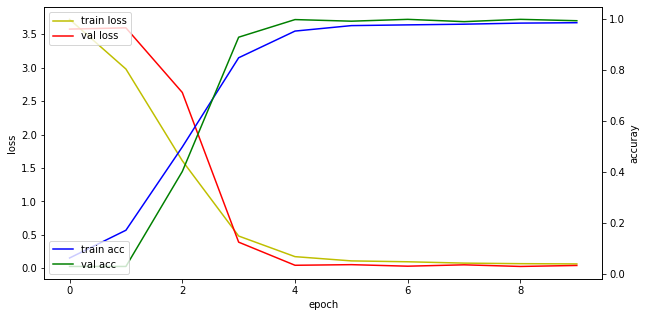

Instructions for updating:
Please use Model.evaluate, which supports generators.
model accuracy: 0.9991


In [12]:
train_generator, val_generator = data_ready()
hist = Make_model(train_generator,val_generator)
print_acc_loss(hist)
model = load_model()
acc = acc_chk(model,val_generator)

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 36, 3)]       0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 36, 36, 64)        283       
_________________________________________________________________
batch_normalization (BatchNo (None, 36, 36, 64)        256       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 36, 36, 64)        4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 36, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 18, 18, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 64)       

## Test

In [21]:
# Test
def predict_img(path):
    img_list = os.listdir(path)
    img_list = natsort.natsorted(img_list, reverse=False)
    result_list = []
    for img_file in img_list:
        if img_file.endswith('.jpg') | img_file.endswith('.png'):
            img = cv2.imread(os.path.join(path, img_file), cv2.IMREAD_COLOR)
            new_img = cv2.resize(img, dsize=(36, 36))
            new_img = new_img.reshape(1, 36, 36, 3)
            result = np.argmax(model.predict(new_img), axis=1)
#             print(img_file,'->', alpha(result[0]))
#             print(model.predict(new_img))
            print(img_file,'-->', result[0])
            result_list.append(result[0])
    return alpha(result_list)

In [23]:
result_aws = predict_img('./test')
result_aws

1_0_382.jpg --> 0
3_0_116.png --> 29
6_0_423.png --> 5
6_0_480.jpg --> 5
17_0_437.jpg --> 15
18_0_585.png --> 16
28_0_10.jpg --> 20
30_0_10.png --> 22
[0, 29, 5, 5, 15, 16, 20, 22]
<class 'str'>
ㅘㅛㅁㅏㅁㅏㄴㄹㅇㅊ


'ㅘㅛ마만ㄹㅇㅊ'

In [24]:
result_aws

'ㅘㅛ마만ㄹㅇㅊ'

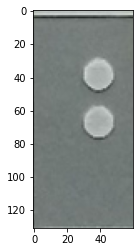

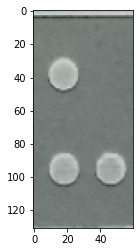

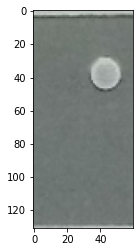

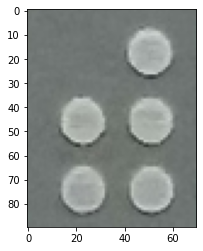

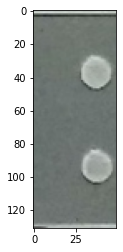

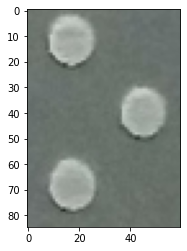

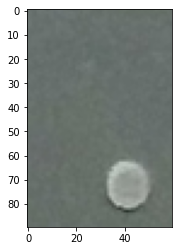

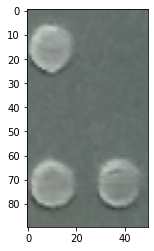

In [42]:
from PIL import Image
plt.imshow

img = Image.open('./jum.png')

x = [img.crop((0, 0, 60, img.size[1])), 
     img.crop((60, 0, 120, img.size[1])), 
     img.crop((130, 0, 190, img.size[1])),
     img.crop((190, 20, 260, 110)), 
     img.crop((270, 0, 320, img.size[1])), 
     img.crop((330, 25, 390, 110)),
     img.crop((400, 20, 460, 110)), 
     img.crop((470, 20, 520, 110))]

for i in range(len(x)):
    plt.imshow(x[i])
    plt.show()